In [63]:
import json
import re
import os
import matplotlib.pyplot as plt
import numpy as np

In [9]:
# get functions
def get_functions():
    with open("functions.json", "r") as f:
        functions = json.load(f)
    return functions

functions = get_functions()
functions

[{'type': 'cache',
  'functions': ['allocate_manager_keys',
   'allocate_vtree_keys',
   'bits2bytes',
   'clist_size',
   'construct_vtree_cache',
   'construct_vtree_key',
   'copy_key',
   'drop_cache_entry',
   'drop_vtree_cache_entries',
   'free_cache_entry',
   'free_manager_keys',
   'free_vtree_cache',
   'free_vtree_keys',
   'insert_cache',
   'lookup_cache',
   'match_keys',
   'set_vtree_hashcode',
   'should_cache']},
 {'type': 'nnf',
  'functions': ['nnf_conjoin',
   'nnf_count_models',
   'nnf_count_nodes',
   'nnf_decomposable',
   'nnf_disjoin',
   'nnf_edge_count',
   'nnf_entails_cnf',
   'nnf_free',
   'nnf_literal2node',
   'nnf_load_from_file',
   'nnf_manager_extract_nnf',
   'nnf_manager_free',
   'nnf_manager_get_root',
   'nnf_manager_memory',
   'nnf_manager_new',
   'save_nnf_manager_to_file',
   'nnf_manager_set_root',
   'nnf_node_count',
   'nnf_save_as_dot',
   'nnf_save_to_file']},
 {'type': 'sat',
  'functions': ['sat_assert_clause',
   'sat_assert_un

In [10]:
def get_function_type(function, functions):
    for category in functions:
        if function in category['functions']:
            return category['type']
    return None

In [11]:
def match_main_line(line):
    children_pct_pattern = r"\s*(?P<children_pct>\d+\.\d+)%"
    self_pct_pattern = r"\s+(?P<self_pct>\d+\.\d+)%"
    command_pattern = r"\s+(?P<command>\S+)"
    sharedobject_pattern = r"\s+(?P<sharedobject>\S+)"
    symbol_pattern = r"\s+\[\.\]\s+(?P<symbol>\S+)"
    pattern = (
        "^" +
        children_pct_pattern +
        self_pct_pattern +
        command_pattern +
        sharedobject_pattern +
        symbol_pattern +
        "$"
    )

    match = re.match(pattern, line)
    if match:
        res = match.groupdict()
        res['children_pct'] = float(res['children_pct'])
        res['self_pct'] = float(res['self_pct'])
        return res
    else:
        return None

In [12]:
def reset_record():
    return {
        "current_fn": None,
        "current_fn_type": None,
        "self_pct": 0,
        "children_pct": 0,
        "running_total": 0,
    }

def get_perf_data(current_file, functions):
    res = []
    record = reset_record()
    with open(current_file, "r") as f:
        for line in f:
            line = line.strip()
            if len(line) == 0 or line.startswith("#"):
                continue
            match = match_main_line(line)
            if match:
                matched_fn = match['symbol']
                matched_fn_type = get_function_type(matched_fn, functions)

                # we have a main line, but the record stores data about the
                # the previous main line
                # save the record and start a new one for the current line
                if record["current_fn"]:
                    if record['current_fn'] and record['current_fn_type']:
                        record["total_pct"] = min(
                            record["self_pct"] + record["running_total"],
                            record["children_pct"]
                        )
                        res.append(record)
                    record = reset_record()

                # we have a main line, but we don't care about the function
                # wait to reach another main line
                # skips the elif after since record is reset
                # ignore any callstacks for this fn
                if matched_fn_type is None:
                    continue

                record['current_fn'] = matched_fn
                record['current_fn_type'] = matched_fn_type
                record['self_pct'] = match['self_pct']
                record['children_pct'] = match['children_pct']
                record['running_total'] = 0
            elif record['current_fn'] and record['current_fn_type']:
                pct, callstack = line.split(maxsplit=1)
                pct = float(pct.replace('%', ''))
                callstack = callstack.split(";")

                # iterate backwards on the callstack
                # if we find the current function *BEFORE* finding any other function
                # we're tracking, then this is a good line
                # otherwise, we skip it
                for fn in reversed(callstack):
                    if fn == record['current_fn']:
                        record['running_total'] += pct
                        break
                    if get_function_type(fn, functions) is not None:
                        break
            else:
                continue

    # make sure to keep last record
    if record['current_fn'] and record['current_fn_type']:
        if res[-1]['current_fn'] != record['current_fn']:
            record["total_pct"] = min(
                record["self_pct"] + record["children_pct"],
                record["children_pct"]
            )
            res.append(record)
    return res

def get_self_total(current_file):
    res = 0
    with open(current_file, "r") as f:
        for line in f:
            line = line.strip()
            if len(line) == 0 or line.startswith("#"):
                continue
            match = match_main_line(line)
            if match:
                res += match['self_pct']
    return res

In [13]:
current_file = "perf_results/s1196.bench.cnf-perf.log"
res = get_perf_data(current_file, functions)

sum_total_pct = sum(record['total_pct'] for record in res)
print(f"sum total pct: {sum_total_pct}")

print(json.dumps(res, indent=4))

sum total pct: 113.19999999999837
[
    {
        "current_fn": "compile_vtree_shannon",
        "current_fn_type": "compile",
        "self_pct": 1.73,
        "children_pct": 75.1,
        "running_total": 38.33999999999855,
        "total_pct": 40.069999999998544
    },
    {
        "current_fn": "compile_dispatcher",
        "current_fn_type": "compile",
        "self_pct": 2.99,
        "children_pct": 75.04,
        "running_total": 4.609999999999987,
        "total_pct": 7.599999999999987
    },
    {
        "current_fn": "compile_vtree_decomposed",
        "current_fn_type": "compile",
        "self_pct": 0.73,
        "children_pct": 74.98,
        "running_total": 8.459999999999908,
        "total_pct": 9.189999999999909
    },
    {
        "current_fn": "compile_vtree",
        "current_fn_type": "compile",
        "self_pct": 0.0,
        "children_pct": 29.05,
        "running_total": 0,
        "total_pct": 0.0
    },
    {
        "current_fn": "lookup_cache",
       

In [14]:
perf_results_dir = "./perf_results/"
perf_results_files = os.listdir(perf_results_dir)
perf_results_files = [f for f in perf_results_files if f.endswith(".cnf-perf.log")]

for f in perf_results_files:
    filename = f"{perf_results_dir}{f}"
    res = get_perf_data(filename, functions)
    self_total = get_self_total(filename)
    sum_total_pct = sum(record['total_pct'] for record in res)
    print(f"filename: {filename} sum total pct: {sum_total_pct}/{self_total} = {sum_total_pct/self_total}")

filename: ./perf_results/par16-5.cnf-perf.log sum total pct: 86.21000000000001/99.32000000000046 = 0.8680024164317318
filename: ./perf_results/log-3.cnf-perf.log sum total pct: 74.66999999999997/96.7800000000005 = 0.7715437073775531
filename: ./perf_results/huge.cnf-perf.log sum total pct: 85.70999999999981/93.9300000000006 = 0.9124880229958401
filename: ./perf_results/ra.cnf-perf.log sum total pct: 67.39999999999999/97.81000000000051 = 0.6890910949800597
filename: ./perf_results/tire-2.cnf-perf.log sum total pct: 92.50999999999983/94.0600000000004 = 0.983521156708478
filename: ./perf_results/c432.isc.cnf-perf.log sum total pct: 100.88999999999936/91.45999999999924 = 1.1031051825934857
filename: ./perf_results/s953.bench.cnf-perf.log sum total pct: 75.01999999999975/91.42000000000043 = 0.8206081820170575
filename: ./perf_results/s641.bench.cnf-perf.log sum total pct: 105.53000000000016/91.21999999999989 = 1.1568734926551227
filename: ./perf_results/bw_large.a.cnf-perf.log sum total pct

In [26]:
# getting time spent
def get_time_spent(stdout_file):
    with open(stdout_file, "r") as f:
        for line in f:
            line = line.strip()
            if line.startswith("Total Time:"):
                time = line.rsplit(maxsplit=1)[1].replace('s', '')
                return float(time)
    return 0

In [27]:
base_cnf = "uf250-026.cnf"
perf_results_dir = "./perf_results/"
stdouts_dir = "./stdouts/"

perf_result = f"{perf_results_dir}{base_cnf}-perf.log"
stdout = f"{stdouts_dir}{base_cnf}.log"

res = get_perf_data(perf_result, functions)
time_spent = get_time_spent(stdout)
print("Time spent", time_spent)

time_per_function = {}
for record in res:
    function_pct = record['total_pct']
    current_function = record['current_fn']
    function_category = record['current_fn_type']
    time_per_function[current_function] = {
        "function_category": function_category,
        "function_pct": function_pct,
    }
    time_per_function[current_function]["time"] = function_pct * time_spent / 100

print(json.dumps(time_per_function, indent=4))

Time spent 1341.967
{
    "compile_vtree_shannon": {
        "function_category": "compile",
        "function_pct": 0.02,
        "time": 0.26839340000000006
    },
    "compile_dispatcher": {
        "function_category": "compile",
        "function_pct": 0.01,
        "time": 0.13419670000000003
    },
    "compile_vtree": {
        "function_category": "compile",
        "function_pct": 0.0,
        "time": 0.0
    },
    "sat_decide_literal": {
        "function_category": "sat",
        "function_pct": 50.92000000000001,
        "time": 683.3295964000001
    },
    "sat_assert_clause": {
        "function_category": "sat",
        "function_pct": 44.5,
        "time": 597.1753150000001
    },
    "lookup_cache": {
        "function_category": "cache",
        "function_pct": 0.18,
        "time": 2.4155406000000004
    },
    "construct_vtree_key": {
        "function_category": "cache",
        "function_pct": 0.16,
        "time": 2.1471472000000005
    },
    "sat_is_implied_l

In [42]:
all_times = {}

cnfs_dir = "./cnfs/"
cnfs_files = os.listdir(cnfs_dir)
cnfs_files = [f for f in cnfs_files if f.endswith(".cnf")]

perf_results_dir = "./perf_results/"
stdouts_dir = "./stdouts/"

for cnf in cnfs_files:
    perf_result_file = f"{perf_results_dir}{cnf}-perf.log"
    stdouts_file = f"{stdouts_dir}{cnf}.log"
    res = get_perf_data(f"{perf_result_file}", functions)
    time_spent = get_time_spent(stdouts_file)
    time_per_function = {}

    for record in res:
        function_pct = record['total_pct']
        current_function = record['current_fn']
        function_category = record['current_fn_type']
        time_per_function[current_function] = {
            "function_category": function_category,
            "function_pct": function_pct,
        }
        function_pct /= 100
        time_per_function[current_function]["time"] = function_pct * time_spent

    all_times[cnf] = time_per_function

In [43]:
print(json.dumps(all_times, indent=4))

{
    "s1488.bench.cnf": {
        "compile_dispatcher": {
            "function_category": "compile",
            "function_pct": 6.869999999999992,
            "time": 0.11520989999999988
        },
        "compile_vtree_shannon": {
            "function_category": "compile",
            "function_pct": 28.490000000000187,
            "time": 0.4777773000000032
        },
        "compile_vtree_decomposed": {
            "function_category": "compile",
            "function_pct": 9.71999999999995,
            "time": 0.16300439999999916
        },
        "compile_vtree": {
            "function_category": "compile",
            "function_pct": 0.0,
            "time": 0.0
        },
        "vtree_manager_new": {
            "function_category": "vtree",
            "function_pct": 12.149999999999942,
            "time": 0.20375549999999903
        },
        "lookup_cache": {
            "function_category": "cache",
            "function_pct": 5.0199999999999925,
            "tim

In [46]:
all_function_times = {}

for f in all_times:
    cnf_times = all_times[f]
    for func in cnf_times:
        if func not in all_function_times:
            all_function_times[func] = {
                "function_category": cnf_times[func]["function_category"],
                "time": 0
            }
        all_function_times[func]["time"] += cnf_times[func]["time"]

print(json.dumps(all_function_times, indent=4))

{
    "compile_dispatcher": {
        "function_category": "compile",
        "time": 13.950187999999995
    },
    "compile_vtree_shannon": {
        "function_category": "compile",
        "time": 49.18565119999971
    },
    "compile_vtree_decomposed": {
        "function_category": "compile",
        "time": 14.58397099999998
    },
    "compile_vtree": {
        "function_category": "compile",
        "time": 0.0011683000000000002
    },
    "vtree_manager_new": {
        "function_category": "vtree",
        "time": 203.14499550000002
    },
    "lookup_cache": {
        "function_category": "cache",
        "time": 23.802147400000003
    },
    "sat_unmark_var": {
        "function_category": "sat",
        "time": 64.80521379999999
    },
    "sat_mark_var": {
        "function_category": "sat",
        "time": 64.65913839999999
    },
    "save_nnf_manager_to_file": {
        "function_category": "nnf",
        "time": 12.82699369999993
    },
    "vtree_is_shannon_node": {
  

In [32]:
total_runtime = 0

stdouts_dir = "./stdouts/"
stdouts_files = os.listdir(stdouts_dir)
stdouts_files = [f for f in stdouts_files if f.endswith(".log")]

for f in stdouts_files:
    stdout_file = f"{stdouts_dir}{f}"
    time_spent = get_time_spent(stdout_file)
    total_runtime += time_spent

print(total_runtime)

2560.438


In [47]:
total_function_runtime = 0
for f in all_function_times:
    total_function_runtime += all_function_times[f]["time"]

print(total_function_runtime)

2238.0157573


In [53]:
for f in all_function_times:
    all_function_times[f]["pct"] = all_function_times[f]["time"] / total_runtime * 100

sorted_function_times = sorted(all_function_times.items(), key=lambda x: x[1]["time"], reverse=True)
sorted_function_times = { k: v for k, v in sorted_function_times }
print(json.dumps(sorted_function_times, indent=4))

total_pct = 0
for f in sorted_function_times:
    total_pct += sorted_function_times[f]["pct"]

print(json.dumps(sorted_function_times, indent=4))
print(total_pct)

{
    "sat_decide_literal": {
        "function_category": "sat",
        "time": 887.9960534,
        "pct": 34.68141206309233
    },
    "sat_assert_clause": {
        "function_category": "sat",
        "time": 640.8415670000002,
        "pct": 25.02859147536477
    },
    "vtree_manager_new": {
        "function_category": "vtree",
        "time": 203.14499550000002,
        "pct": 7.9339939299447995
    },
    "construct_vtree_key": {
        "function_category": "cache",
        "time": 111.8505834999999,
        "pct": 4.368416009292156
    },
    "sat_unmark_var": {
        "function_category": "sat",
        "time": 64.80521379999999,
        "pct": 2.531020622252911
    },
    "sat_mark_var": {
        "function_category": "sat",
        "time": 64.65913839999999,
        "pct": 2.525315528046373
    },
    "compile_vtree_shannon": {
        "function_category": "compile",
        "time": 49.18565119999971,
        "pct": 1.9209858313304093
    },
    "sat_is_implied_literal"

In [54]:
category_pcts = {}
for f in sorted_function_times:
    category = sorted_function_times[f]["function_category"]
    if category not in category_pcts:
        category_pcts[category] = 0
    category_pcts[category] += sorted_function_times[f]["pct"]

category_pcts = sorted(category_pcts.items(), key=lambda x: x[1], reverse=True)
category_pcts = { k: v for k, v in category_pcts }
print(json.dumps(category_pcts, indent=4))

{
    "sat": 69.25831076948555,
    "vtree": 8.52854987310765,
    "cache": 6.046549379442106,
    "compile": 3.03545637504207,
    "nnf": 0.538669239403568
}


In [67]:
file_to_sat_percent = {}

for file in all_times:
    stdout_file = f"{stdouts_dir}{file}.log"
    time_spent = get_time_spent(stdout_file)

    sat_time = 0
    for func in all_times[file]:
        if all_times[file][func]["function_category"] == "sat":
            sat_time += all_times[file][func]["time"]

    file_to_sat_percent[file] = {
        "sat_time": sat_time,
        "sat_percent": sat_time / time_spent * 100,
        "total_time": time_spent
    }

file_to_sat_percent = sorted(file_to_sat_percent.items(), key=lambda x: x[1]["total_time"])
file_to_sat_percent = { k: v for k, v in file_to_sat_percent }
print(json.dumps(file_to_sat_percent, indent=4))

{
    "s838.1.bench.cnf": {
        "sat_time": 0.013777999999999999,
        "sat_percent": 16.599999999999998,
        "total_time": 0.083
    },
    "s510.bench.cnf": {
        "sat_time": 0.017712000000000002,
        "sat_percent": 19.680000000000003,
        "total_time": 0.09
    },
    "cnt06.shuffled.cnf": {
        "sat_time": 0.0568176,
        "sat_percent": 33.82,
        "total_time": 0.168
    },
    "ssa7552-038.cnf": {
        "sat_time": 0.12097309999999999,
        "sat_percent": 34.27,
        "total_time": 0.353
    },
    "tire-2.cnf": {
        "sat_time": 0.1326708,
        "sat_percent": 32.28,
        "total_time": 0.411
    },
    "tire-3.cnf": {
        "sat_time": 0.1347042,
        "sat_percent": 29.219999999999995,
        "total_time": 0.461
    },
    "s641.bench.cnf": {
        "sat_time": 0.08634599999999999,
        "sat_percent": 18.449999999999996,
        "total_time": 0.468
    },
    "2bitcomp_5.cnf": {
        "sat_time": 0.08623439999999999,
 

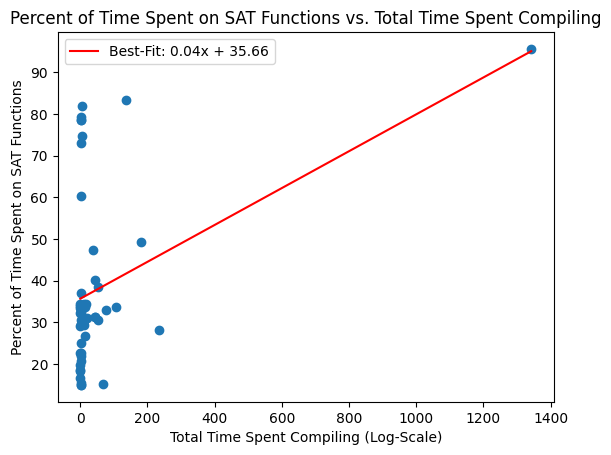

In [74]:
times = []
sat_percents = []
for file in file_to_sat_percent:
    times.append(file_to_sat_percent[file]["total_time"])
    sat_percents.append(file_to_sat_percent[file]["sat_percent"])

plt.scatter(times, sat_percents)
plt.title("Percent of Time Spent on SAT Functions vs. Total Time Spent Compiling")
plt.xlabel("Total Time Spent Compiling (Log-Scale)")
plt.ylabel("Percent of Time Spent on SAT Functions")

if len(times) > 1:
    coeffs = np.polyfit(times, sat_percents, 1)
    poly = np.poly1d(coeffs)
    plt.plot(times, poly(times), color="red", label=f"Best-Fit: {coeffs[0]:.2f}x + {coeffs[1]:.2f}")

plt.legend()
plt.show()

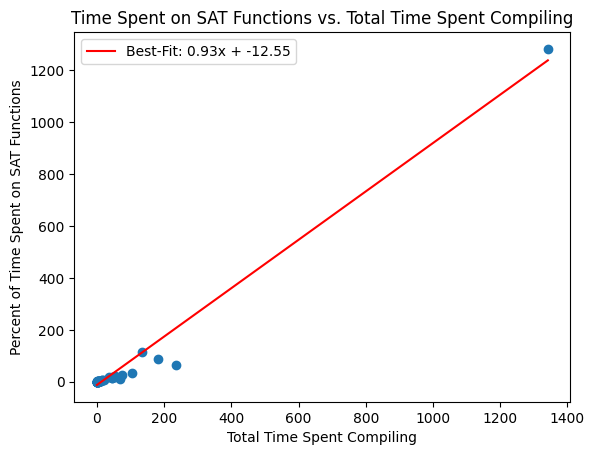

In [72]:
times = []
sat_times = []
for file in file_to_sat_percent:
    times.append(file_to_sat_percent[file]["total_time"])
    sat_times.append(file_to_sat_percent[file]["sat_time"])

plt.scatter(times, sat_times)
plt.title("Time Spent on SAT Functions vs. Total Time Spent Compiling")
plt.xlabel("Total Time Spent Compiling")
plt.ylabel("Percent of Time Spent on SAT Functions")

if len(times) > 1:
    coeffs = np.polyfit(times, sat_times, 1)
    poly = np.poly1d(coeffs)
    plt.plot(times, poly(times), color="red", label=f"Best-Fit: {coeffs[0]:.2f}x + {coeffs[1]:.2f}")

plt.legend()
plt.show()